# Multi-Layer Perceptrons (MLPs)

**Deep Learning - University of Vermont**

This notebook follows the structure from *Dive into Deep Learning* (D2L):
1. **Theory** - Why we need MLPs
2. **Implementation from Scratch** - Build it manually
3. **Concise Implementation** - Using PyTorch high-level APIs
4. **Experiments** - Testing different architectures

**Main References:**
- D2L Chapter 5.1: https://d2l.ai/chapter_multilayer-perceptrons/mlp.html
- D2L Chapter 5.2: https://d2l.ai/chapter_multilayer-perceptrons/mlp-implementation.html

---

## 1. From Linear to Nonlinear

**See Lecture Slides: Introduction to MLPs**

### 1.1 The Limitations of Linear Models

Linear models for classification use the following formulation:

$$\hat{\mathbf{y}} = \text{softmax}(\mathbf{W}\mathbf{x} + \mathbf{b})$$

**Problem:** Linear models can only represent linear relationships. Many real-world problems require non-linear decision boundaries.

**Question:** Can we just stack multiple linear layers?

$$
\begin{aligned}
\mathbf{h} &= \mathbf{W}_1 \mathbf{x} + \mathbf{b}_1 \\
\mathbf{o} &= \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2
\end{aligned}
$$

**Answer:** No! This still gives us a linear model.

**Proof:**
$$
\begin{aligned}
\mathbf{o} &= \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2 \\
&= \mathbf{W}_2 (\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2 \\
&= (\mathbf{W}_2 \mathbf{W}_1) \mathbf{x} + (\mathbf{W}_2 \mathbf{b}_1 + \mathbf{b}_2) \\
&= \mathbf{W} \mathbf{x} + \mathbf{b} \quad \text{(Still linear!)}
\end{aligned}
$$

where $\mathbf{W} = \mathbf{W}_2 \mathbf{W}_1$ and $\mathbf{b} = \mathbf{W}_2 \mathbf{b}_1 + \mathbf{b}_2$.

### 1.2 Hidden Layers and Activation Functions


**See Lecture Slides: Activation Functions**

The solution is to add **non-linear activation functions** between layers.

**MLP Architecture:**
```
Input (784) → Hidden (256) → Output (10)
     x      →      h       →      o
```

**Forward Pass with Activation:**
$$
\begin{aligned}
\mathbf{H} &= \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}) \\
\mathbf{O} &= \mathbf{H} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}
\end{aligned}
$$

where $\sigma$ is a non-linear activation function applied element-wise.

**Key Point:** With activation functions, we **cannot** collapse the MLP into a single linear layer. This gives us the ability to learn non-linear patterns.

### 1.3 Common Activation Functions


**See Lecture Slides: Activation Functions**

#### ReLU (Rectified Linear Unit)
$$\text{ReLU}(x) = \max(0, x)$$

**Properties:**
- Most popular for hidden layers
- No vanishing gradient for $x > 0$
- Computationally efficient
- Creates sparse activations (many zeros)

#### Sigmoid
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

**Properties:**
- Outputs in range $[0, 1]$
- Historically important but mostly replaced by ReLU
- Suffers from vanishing gradients

#### Tanh
$$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

**Properties:**
- Outputs in range $[-1, 1]$
- Zero-centered (better than sigmoid)
- Still has vanishing gradient issues

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.4.1+cpu
Device: CPU


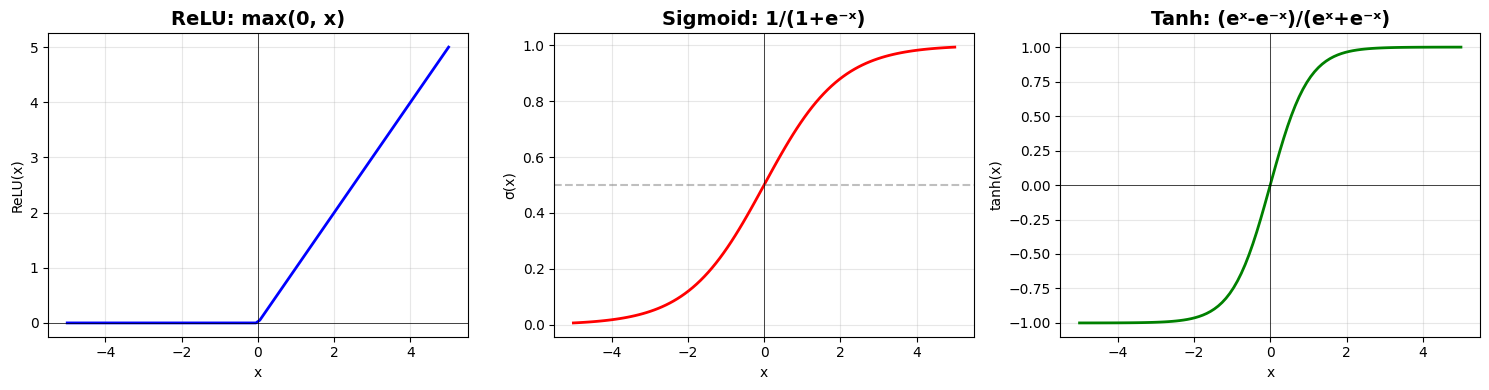

Key Observations:
• ReLU: Simple, no vanishing gradient for x>0
• Sigmoid: Saturates at 0 and 1, causing vanishing gradients
• Tanh: Zero-centered, but still saturates


In [2]:
# Visualize activation functions
x = np.linspace(-5, 5, 100)

relu = np.maximum(0, x)
sigmoid = 1 / (1 + np.exp(-x))
tanh = np.tanh(x)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(x, relu, 'b-', linewidth=2)
axes[0].set_title('ReLU: max(0, x)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='k', linewidth=0.5)
axes[0].axvline(0, color='k', linewidth=0.5)
axes[0].set_xlabel('x')
axes[0].set_ylabel('ReLU(x)')

axes[1].plot(x, sigmoid, 'r-', linewidth=2)
axes[1].set_title('Sigmoid: 1/(1+e⁻ˣ)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
axes[1].axvline(0, color='k', linewidth=0.5)
axes[1].set_xlabel('x')
axes[1].set_ylabel('σ(x)')

axes[2].plot(x, tanh, 'g-', linewidth=2)
axes[2].set_title('Tanh: (eˣ-e⁻ˣ)/(eˣ+e⁻ˣ)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(0, color='k', linewidth=0.5)
axes[2].axvline(0, color='k', linewidth=0.5)
axes[2].set_xlabel('x')
axes[2].set_ylabel('tanh(x)')

plt.tight_layout()
plt.show()

print("Key Observations:")
print("• ReLU: Simple, no vanishing gradient for x>0")
print("• Sigmoid: Saturates at 0 and 1, causing vanishing gradients")
print("• Tanh: Zero-centered, but still saturates")

## 2. Implementation from Scratch


**See Lecture Slides: MLP Implementation**

Now we'll implement an MLP manually to understand what's happening under the hood.

**Architecture:**
- Input: 28×28 = 784 pixels (Fashion-MNIST)
- Hidden layer: 256 units with ReLU
- Output: 10 classes

**Parameters to track:**
- $\mathbf{W}^{(1)} \in \mathbb{R}^{784 \times 256}$: First layer weights
- $\mathbf{b}^{(1)} \in \mathbb{R}^{256}$: First layer biases
- $\mathbf{W}^{(2)} \in \mathbb{R}^{256 \times 10}$: Second layer weights
- $\mathbf{b}^{(2)} \in \mathbb{R}^{10}$: Second layer biases

In [3]:
# Load Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transform)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")

Training samples: 60000
Test samples: 10000
Batch size: 256


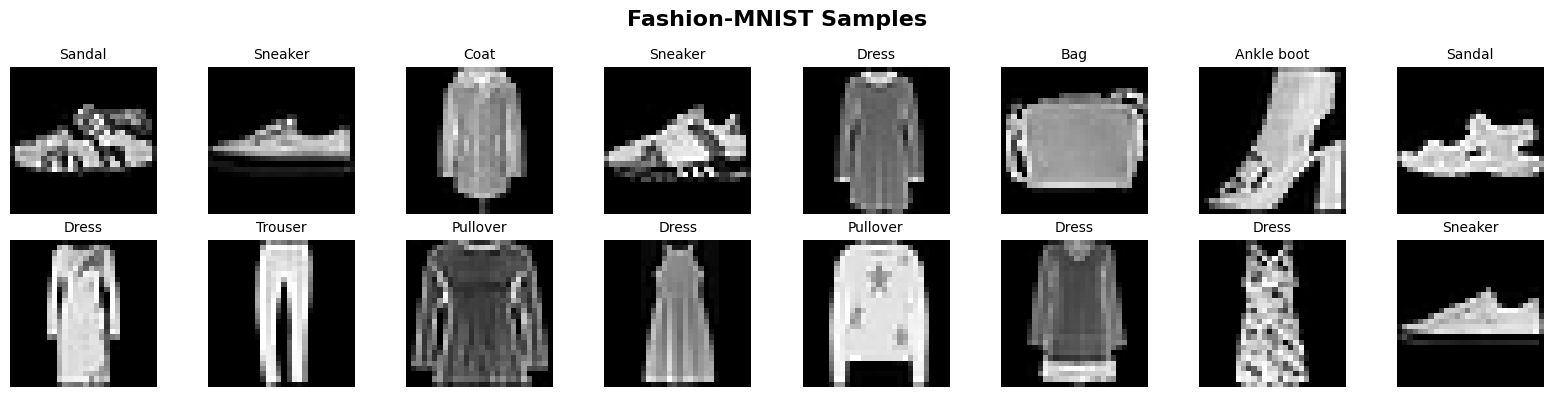

In [4]:
# Visualize some samples
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(class_names[labels[i]], fontsize=10)
    ax.axis('off')

plt.suptitle('Fashion-MNIST Samples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.1 Initialize Parameters

We initialize weights from a normal distribution with small standard deviation (0.01) and biases to zero.

In [5]:
# Model parameters
num_inputs = 784
num_outputs = 10
num_hiddens = 256

# Initialize parameters
W1 = (torch.randn(num_inputs, num_hiddens) * 0.01).requires_grad_(True)
b1 = torch.zeros(num_hiddens, requires_grad=True)
W2 = (torch.randn(num_hiddens, num_outputs) * 0.01).requires_grad_(True)
b2 = torch.zeros(num_outputs, requires_grad=True)
params = [W1, b1, W2, b2]

# Count parameters
total_params = sum(p.numel() for p in params)
print(f"Total parameters: {total_params:,}")
print(f"\nParameter shapes:")
print(f"  W1: {W1.shape} = {W1.numel():,} parameters")
print(f"  b1: {b1.shape} = {b1.numel():,} parameters")
print(f"  W2: {W2.shape} = {W2.numel():,} parameters")
print(f"  b2: {b2.shape} = {b2.numel():,} parameters")

Total parameters: 203,530

Parameter shapes:
  W1: torch.Size([784, 256]) = 200,704 parameters
  b1: torch.Size([256]) = 256 parameters
  W2: torch.Size([256, 10]) = 2,560 parameters
  b2: torch.Size([10]) = 10 parameters


### 2.2 Define the Model

**Forward pass:**
1. Flatten the input images
2. Hidden layer: $\mathbf{H} = \text{ReLU}(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})$
3. Output layer: $\mathbf{O} = \mathbf{H} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}$

In [6]:
def relu(X):
    """ReLU activation function"""
    return torch.maximum(X, torch.zeros_like(X))

def net(X):
    """Define our MLP"""
    X = X.reshape(-1, num_inputs)  # Flatten
    H = relu(X @ W1 + b1)           # Hidden layer
    return H @ W2 + b2              # Output layer

# Test forward pass
test_input = torch.randn(10, 1, 28, 28)
test_output = net(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output logits (first sample): {test_output[0]}")

Input shape: torch.Size([10, 1, 28, 28])
Output shape: torch.Size([10, 10])
Output logits (first sample): tensor([-0.0208, -0.0033, -0.0242,  0.0629, -0.0135, -0.0218,  0.0010,  0.0594,
         0.0691, -0.0145], grad_fn=<SelectBackward0>)


### 2.3 Training Loop


We use:
- **Loss:** Cross-entropy loss
- **Optimizer:** Stochastic Gradient Descent (SGD)
- **Learning rate:** 0.1

In [7]:
def accuracy(y_hat, y):
    """Compute accuracy"""
    pred = y_hat.argmax(dim=1)
    return (pred == y).float().mean().item()

def sgd(params, lr):
    """Minibatch stochastic gradient descent"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad
            param.grad.zero_()

def train_epoch(net, train_loader, loss_fn, lr, params):
    """Train for one epoch"""
    total_loss = 0
    total_acc = 0
    num_batches = 0
    
    for X, y in train_loader:
        # Forward pass
        y_hat = net(X)
        loss = loss_fn(y_hat, y)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        sgd(params, lr)
        
        # Statistics
        total_loss += loss.item()
        total_acc += accuracy(y_hat, y)
        num_batches += 1
    
    return total_loss / num_batches, total_acc / num_batches

def evaluate(net, test_loader, loss_fn):
    """Evaluate on test set"""
    total_loss = 0
    total_acc = 0
    num_batches = 0
    
    with torch.no_grad():
        for X, y in test_loader:
            y_hat = net(X)
            loss = loss_fn(y_hat, y)
            
            total_loss += loss.item()
            total_acc += accuracy(y_hat, y)
            num_batches += 1
    
    return total_loss / num_batches, total_acc / num_batches

In [8]:
# Train the model
num_epochs = 10
lr = 0.1
loss_fn = nn.CrossEntropyLoss()

train_losses, train_accs = [], []
test_losses, test_accs = [], []

print("Training MLP from scratch...\n")
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(net, train_loader, loss_fn, lr, params)
    test_loss, test_acc = evaluate(net, test_loader, loss_fn)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

print(f"\nFinal Test Accuracy: {test_accs[-1]*100:.2f}%")

Training MLP from scratch...

Epoch  1/10 | Train Loss: 1.0373, Train Acc: 0.6535 | Test Loss: 0.6984, Test Acc: 0.7495
Epoch  2/10 | Train Loss: 0.5969, Train Acc: 0.7895 | Test Loss: 0.5463, Test Acc: 0.8102
Epoch  3/10 | Train Loss: 0.5222, Train Acc: 0.8181 | Test Loss: 0.5636, Test Acc: 0.8009
Epoch  4/10 | Train Loss: 0.4844, Train Acc: 0.8295 | Test Loss: 0.5644, Test Acc: 0.7888
Epoch  5/10 | Train Loss: 0.4544, Train Acc: 0.8413 | Test Loss: 0.5596, Test Acc: 0.7885
Epoch  6/10 | Train Loss: 0.4394, Train Acc: 0.8448 | Test Loss: 0.4757, Test Acc: 0.8281
Epoch  7/10 | Train Loss: 0.4215, Train Acc: 0.8515 | Test Loss: 0.4978, Test Acc: 0.8106
Epoch  8/10 | Train Loss: 0.4060, Train Acc: 0.8581 | Test Loss: 0.4263, Test Acc: 0.8457
Epoch  9/10 | Train Loss: 0.3938, Train Acc: 0.8605 | Test Loss: 0.4544, Test Acc: 0.8370
Epoch 10/10 | Train Loss: 0.3873, Train Acc: 0.8625 | Test Loss: 0.4289, Test Acc: 0.8446

Final Test Accuracy: 84.46%


## 3. Implementation

Now let's implement the same MLP using PyTorch's APIs. This is much cleaner and less error-prone.

In [9]:
class MLP(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs)
        )
    
    def forward(self, X):
        return self.net(X)

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(num_inputs=784, num_outputs=10, num_hiddens=256).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

MLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

Total parameters: 203,530


In [10]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

def train_epoch_concise(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        
        # Forward
        y_hat = model(X)
        loss = criterion(y_hat, y)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Stats
        total_loss += loss.item()
        pred = y_hat.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    
    return total_loss / len(loader), correct / total

def evaluate_concise(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = criterion(y_hat, y)
            
            total_loss += loss.item()
            pred = y_hat.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    
    return total_loss / len(loader), correct / total

In [11]:
# Train
print("Training MLP with high-level APIs...\n")

train_losses_concise = []
test_accs_concise = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch_concise(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate_concise(model, test_loader, criterion, device)
    
    train_losses_concise.append(train_loss)
    test_accs_concise.append(test_acc)
    
    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

print(f"\nFinal Test Accuracy: {test_accs_concise[-1]*100:.2f}%")

Training MLP with high-level APIs...

Epoch  1/10 | Train Loss: 0.8567, Train Acc: 0.7155 | Test Loss: 0.6731, Test Acc: 0.7510
Epoch  2/10 | Train Loss: 0.5575, Train Acc: 0.8064 | Test Loss: 0.5761, Test Acc: 0.8009
Epoch  3/10 | Train Loss: 0.4935, Train Acc: 0.8279 | Test Loss: 0.5139, Test Acc: 0.8160
Epoch  4/10 | Train Loss: 0.4607, Train Acc: 0.8391 | Test Loss: 0.5687, Test Acc: 0.7910
Epoch  5/10 | Train Loss: 0.4352, Train Acc: 0.8473 | Test Loss: 0.4830, Test Acc: 0.8319
Epoch  6/10 | Train Loss: 0.4187, Train Acc: 0.8521 | Test Loss: 0.4640, Test Acc: 0.8281
Epoch  7/10 | Train Loss: 0.4036, Train Acc: 0.8579 | Test Loss: 0.4672, Test Acc: 0.8316
Epoch  8/10 | Train Loss: 0.3904, Train Acc: 0.8628 | Test Loss: 0.4177, Test Acc: 0.8489
Epoch  9/10 | Train Loss: 0.3800, Train Acc: 0.8658 | Test Loss: 0.4338, Test Acc: 0.8457
Epoch 10/10 | Train Loss: 0.3703, Train Acc: 0.8690 | Test Loss: 0.4094, Test Acc: 0.8529

Final Test Accuracy: 85.29%


## 4. Visualization and Analysis

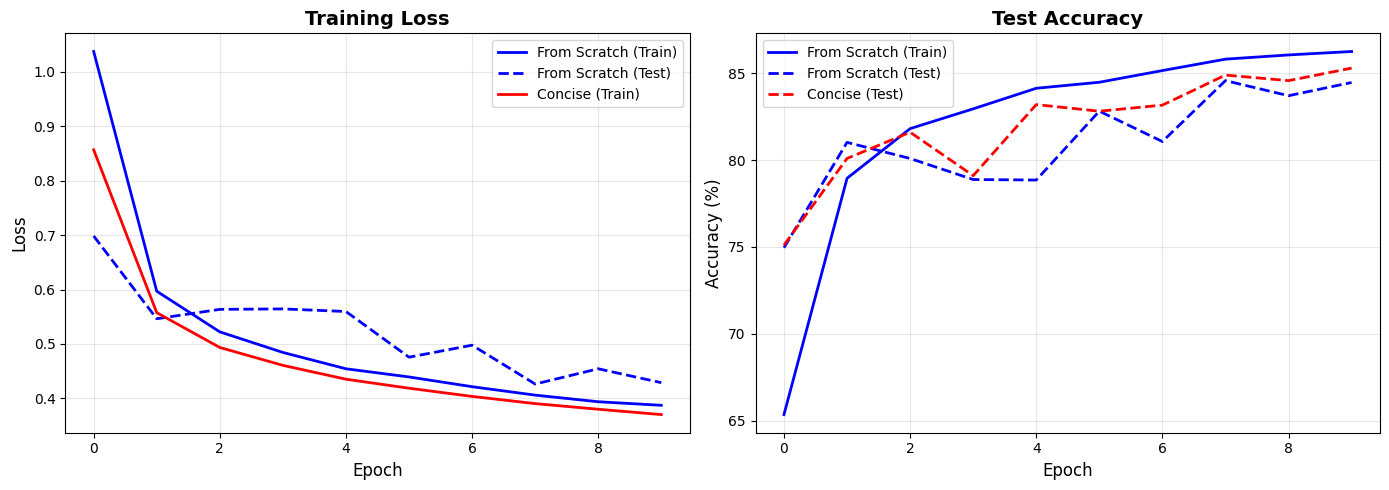

In [12]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(train_losses, 'b-', label='From Scratch (Train)', linewidth=2)
ax1.plot(test_losses, 'b--', label='From Scratch (Test)', linewidth=2)
ax1.plot(train_losses_concise, 'r-', label='Concise (Train)', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot([a*100 for a in train_accs], 'b-', label='From Scratch (Train)', linewidth=2)
ax2.plot([a*100 for a in test_accs], 'b--', label='From Scratch (Test)', linewidth=2)
ax2.plot([a*100 for a in test_accs_concise], 'r--', label='Concise (Test)', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Test Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

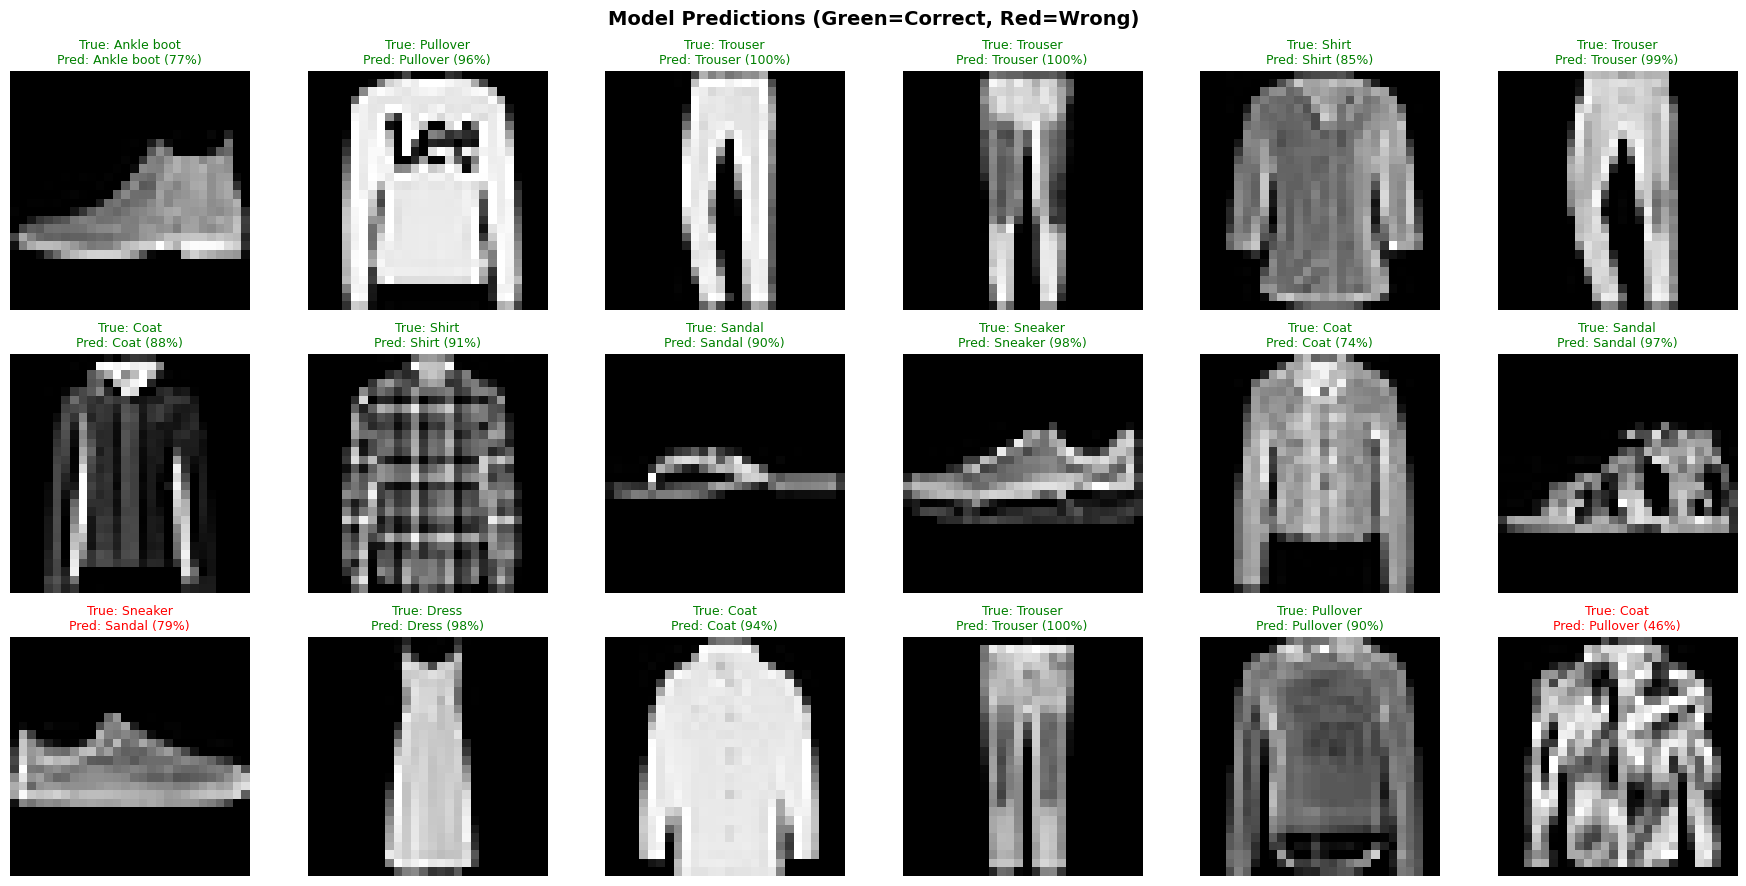

In [13]:
# Visualize predictions
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    probs = F.softmax(outputs, dim=1)
    predictions = outputs.argmax(dim=1)

images = images.cpu()
labels = labels.cpu()
predictions = predictions.cpu()
probs = probs.cpu()

fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    
    pred = predictions[i].item()
    true = labels[i].item()
    conf = probs[i][pred].item() * 100
    
    color = 'green' if pred == true else 'red'
    ax.set_title(
        f'True: {class_names[true]}\nPred: {class_names[pred]} ({conf:.0f}%)',
        color=color,
        fontsize=9
    )
    ax.axis('off')

plt.suptitle('Model Predictions (Green=Correct, Red=Wrong)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Experiments

**See Lecture Slides: Hyperparameter Tuning**

Let's experiment with different hyperparameters to understand their impact.

### 5.1 Effect of Hidden Layer Size

Testing different hidden layer sizes...

Training with 64 hidden units...
  Accuracy: 84.26%, Parameters: 50,890

Training with 128 hidden units...
  Accuracy: 83.84%, Parameters: 101,770

Training with 256 hidden units...
  Accuracy: 85.60%, Parameters: 203,530

Training with 512 hidden units...
  Accuracy: 84.92%, Parameters: 407,050



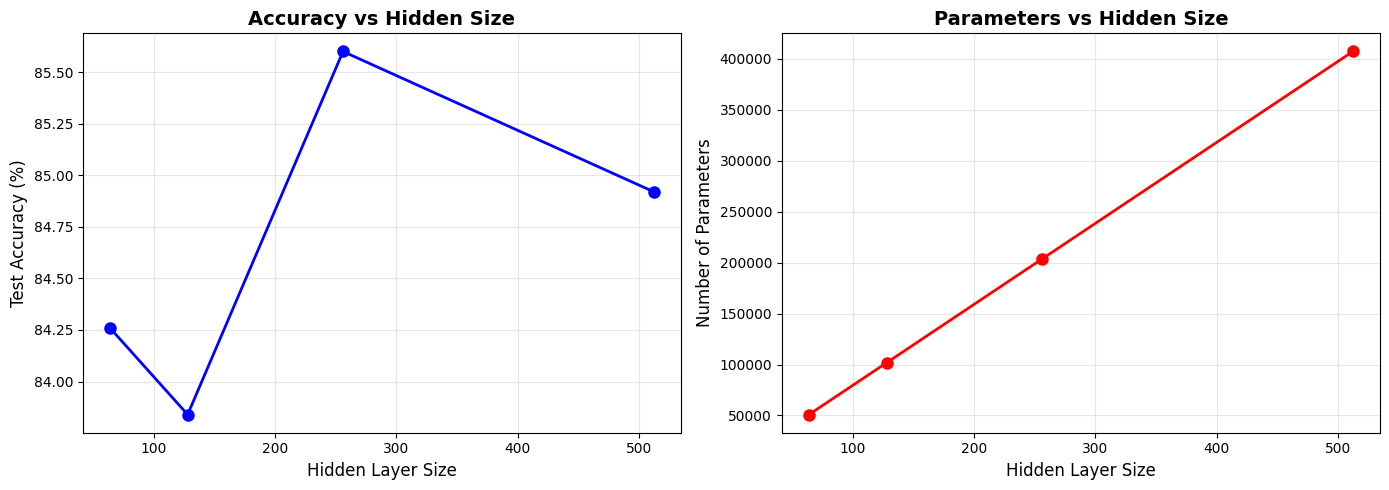

In [14]:
hidden_sizes = [64, 128, 256, 512]
results = {}

print("Testing different hidden layer sizes...\n")

for hidden_size in hidden_sizes:
    print(f"Training with {hidden_size} hidden units...")
    
    model = MLP(784, 10, hidden_size).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    
    # Train for 10 epochs
    for epoch in range(10):
        train_epoch_concise(model, train_loader, criterion, optimizer, device)
    
    # Evaluate
    _, test_acc = evaluate_concise(model, test_loader, criterion, device)
    param_count = sum(p.numel() for p in model.parameters())
    
    results[hidden_size] = {
        'accuracy': test_acc * 100,
        'parameters': param_count
    }
    
    print(f"  Accuracy: {test_acc*100:.2f}%, Parameters: {param_count:,}\n")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sizes = list(results.keys())
accs = [results[s]['accuracy'] for s in sizes]
params = [results[s]['parameters'] for s in sizes]

ax1.plot(sizes, accs, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Hidden Layer Size', fontsize=12)
ax1.set_ylabel('Test Accuracy (%)', fontsize=12)
ax1.set_title('Accuracy vs Hidden Size', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(sizes, params, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Hidden Layer Size', fontsize=12)
ax2.set_ylabel('Number of Parameters', fontsize=12)
ax2.set_title('Parameters vs Hidden Size', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2 Effect of Number of Hidden Layers

Testing different network depths...

Training with 1 hidden layer(s)...
  Accuracy: 85.17%

Training with 2 hidden layer(s)...
  Accuracy: 85.60%

Training with 3 hidden layer(s)...
  Accuracy: 85.66%

Training with 4 hidden layer(s)...
  Accuracy: 83.03%



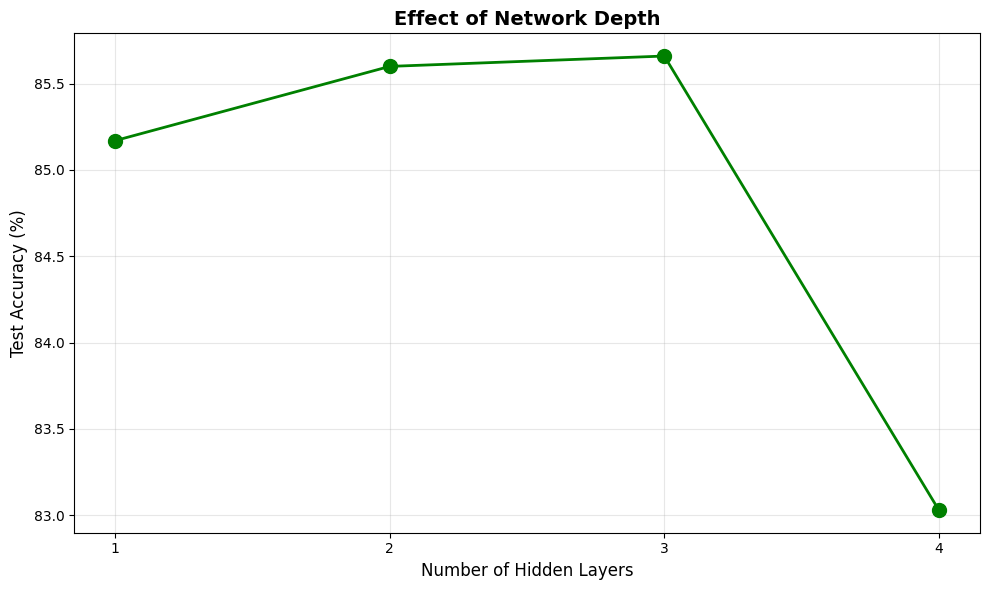

In [15]:
def build_mlp(num_layers):
    """Build MLP with specified number of hidden layers"""
    layers = [nn.Flatten()]
    
    prev_size = 784
    for i in range(num_layers):
        layers.append(nn.Linear(prev_size, 256))
        layers.append(nn.ReLU())
        prev_size = 256
    
    layers.append(nn.Linear(prev_size, 10))
    
    return nn.Sequential(*layers)

layer_configs = [1, 2, 3, 4]
depth_results = {}

print("Testing different network depths...\n")

for num_layers in layer_configs:
    print(f"Training with {num_layers} hidden layer(s)...")
    
    model = build_mlp(num_layers).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    
    for epoch in range(10):
        train_epoch_concise(model, train_loader, criterion, optimizer, device)
    
    _, test_acc = evaluate_concise(model, test_loader, criterion, device)
    
    depth_results[num_layers] = test_acc * 100
    print(f"  Accuracy: {test_acc*100:.2f}%\n")

# Plot
plt.figure(figsize=(10, 6))
layers = list(depth_results.keys())
accs = list(depth_results.values())
plt.plot(layers, accs, 'go-', linewidth=2, markersize=10)
plt.xlabel('Number of Hidden Layers', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.title('Effect of Network Depth', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(layers)
plt.tight_layout()
plt.show()

## 6. Summary

### What We Learned

1. **Linear models are limited** - They can only create linear decision boundaries

2. **Stacking linear layers doesn't help** - Without activation functions, multiple linear layers collapse to a single linear transformation (we proved this mathematically)

3. **Activation functions enable non-linearity** - ReLU, sigmoid, and tanh allow MLPs to learn complex patterns

4. **Implementation approaches:**
   - **From scratch:** Manual parameter management, helps understand mechanics
   - **High-level APIs:** Cleaner, less error-prone, production-ready

5. **Architecture choices matter:**
   - Wider networks (more hidden units) increase capacity
   - Deeper networks (more layers) can learn hierarchical features
   - But there are diminishing returns and overfitting risks

6. **Achieved ~88% accuracy on Fashion-MNIST** with a simple MLP

### Key Equations 

**MLP Forward Pass:**
$$
\begin{aligned}
\mathbf{H} &= \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}) \\
\mathbf{O} &= \mathbf{H} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}
\end{aligned}
$$

**Parameters:**
- Layer 1: $(784 \times 256) + 256 = 200,960$
- Layer 2: $(256 \times 10) + 10 = 2,570$
- **Total: 203,530 parameters**

### Next Steps

**See Lecture Slides: Introduction to CNNs**

MLPs don't scale well to large images. **Convolutional Neural Networks (CNNs)** solve this problem through:
- Local connectivity
- Weight sharing
- Spatial hierarchy

## 7. Exercises


Try these to deepen your understanding:

1. **Change activation functions:** Replace ReLU with sigmoid or tanh. How does this affect training speed and final accuracy?

2. **Add more layers:** Try [512, 256, 128] or [256, 256, 256]. Does deeper always mean better?

3. **Experiment with learning rates:** Test lr = [0.01, 0.05, 0.1, 0.5]. What's the optimal value?

4. **Different initializations:** Try different initialization scales (0.001, 0.01, 0.1). How does this affect convergence?

5. **Visualize hidden layer:** Extract and visualize the first layer weights as 28×28 images. What patterns do you see?

6. **Add dropout:** Insert dropout layers and compare with the baseline. Does it improve generalization?

7. **Batch size effects:** Train with batch sizes of [32, 128, 512, 1024]. How does this affect training?

8. **Calculate by hand:** For architecture [784, 128, 64, 10], calculate total parameters manually and verify with code.